In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import psutil
import os
import time
import tracemalloc
import psutil
import sys
from pympler import asizeof
import matplotlib.pyplot as plt
from river import imblearn
from scipy.stats import ttest_rel
import itertools

from river import compose, preprocessing, metrics, stream, linear_model, evaluate
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import NearestNeighbors
from ALMASWA import ALMASWAClassifier

from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from Hamming import HammingLoss
import seaborn as sns
from tqdm import tqdm 

In [2]:
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")
data.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,172.31.69.12,52246,172.31.0.2,53,17,5.126,197,357,3,3,0,0,1,Infilteration
1,172.31.69.12,61337,172.31.0.2,53,17,0.000,173,362,2,2,0,0,1,Infilteration
2,172.31.69.12,51705,172.31.0.2,53,17,0.000,131,397,2,2,0,0,1,Infilteration
3,172.31.69.12,65416,172.31.0.2,53,17,5.178,164,324,2,2,0,0,1,Infilteration
4,172.31.69.12,53887,172.31.0.2,53,17,5.212,136,273,2,2,0,0,1,Infilteration


In [3]:
print('Original dataset shape  %s' % Counter(data['Attack']))

Original dataset shape  Counter({'DDoS attacks-LOIC-HTTP': 378199, 'FTP-BruteForce': 193360, 'DoS attacks-Hulk': 108136, 'DoS attacks-SlowHTTPTest': 105550, 'Benign': 100000, 'SSH-Bruteforce': 94237, 'Infilteration': 62072, 'DoS attacks-GoldenEye': 32850, 'DoS attacks-Slowloris': 22825, 'Bot': 15683, 'Brute Force -Web': 2613, 'Brute Force -XSS': 1745, 'DDOS attack-LOIC-UDP': 1667, 'DDOS attack-HOIC': 230, 'SQL Injection': 36})


## Experiment 1: Comparing ALMA with ALMASWA on the complete dataset

In [4]:
# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")

--- ALMAClassifier ---
Accuracy: 0.9913
Recall: 0.9919
--- ALMASWAClassifier ---
Accuracy: 0.9981
Recall: 0.9995


## Experiment 2: Comparing ALMA with ALMASWA on different attack classes

### DDoS attack class

In [5]:
# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE-DDoS.csv")
print('Original dataset shape  %s' % Counter(data['Attack']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")

Original dataset shape  Counter({'DDoS attacks-LOIC-HTTP': 378199, 'Benign': 100000, 'DDOS attack-LOIC-UDP': 1667, 'DDOS attack-HOIC': 230})
--- ALMAClassifier ---
Accuracy: 0.9961
Recall: 0.9976
--- ALMASWAClassifier ---
Accuracy: 0.9986
Recall: 0.9997


### DoS attack class

In [6]:
# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE-DoS.csv")
print('Original dataset shape  %s' % Counter(data['Attack']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")

Original dataset shape  Counter({'DoS attacks-Hulk': 108136, 'DoS attacks-SlowHTTPTest': 105550, 'Benign': 100000, 'DoS attacks-GoldenEye': 32850, 'DoS attacks-Slowloris': 22825})
--- ALMAClassifier ---
Accuracy: 0.9912
Recall: 0.9943
--- ALMASWAClassifier ---
Accuracy: 0.9953
Recall: 1.0000


### Infiltration attack class

In [7]:
# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE-Infiltration.csv")
print('Original dataset shape  %s' % Counter(data['Attack']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")

Original dataset shape  Counter({'Benign': 100000, 'Infilteration': 62072})
--- ALMAClassifier ---
Accuracy: 0.9953
Recall: 0.9943
--- ALMASWAClassifier ---
Accuracy: 0.9976
Recall: 0.9945


### Injection attack class

In [8]:
# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE-Injection.csv")
print('Original dataset shape  %s' % Counter(data['Attack']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'Recall': metrics.Recall()
    }
    for name in classifiers
}

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    for name, model in classifiers.items():
        y_pred = model.predict_one(x)
        model.learn_one(x, true_y)
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['Recall'].update(true_y, y_pred)

# Display the results
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"Recall: {metric['Recall'].get():.4f}")

Original dataset shape  Counter({'FTP-BruteForce': 193360, 'Benign': 100000, 'SSH-Bruteforce': 94237, 'Brute Force -Web': 2613, 'Brute Force -XSS': 1745})
--- ALMAClassifier ---
Accuracy: 0.9924
Recall: 0.9953
--- ALMASWAClassifier ---
Accuracy: 0.9955
Recall: 0.9997


## Checking for features to use for introduction 

### Statistical characteristic of each feature. 

In [9]:
import pandas as pd

# Load data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)

# Compute statistical summaries
summary_stats = X.describe().T  # Compute mean, std, min, 25%, 50%, 75%, max
summary_stats['Skewness'] = X.skew()  # Add skewness
summary_stats['Kurtosis'] = X.kurt()  # Add kurtosis

# Print the numerical summaries
print("Feature Distribution Summary:")
print(summary_stats)

Feature Distribution Summary:
                                count           mean           std   min  \
L4_SRC_PORT                 1119203.0   46684.717165  1.685553e+04   0.0   
L4_DST_PORT                 1119203.0    4356.292920  1.358867e+04   0.0   
PROTOCOL                    1119203.0       6.407728  2.082339e+00   1.0   
L7_PROTO                    1119203.0       3.152786  1.859839e+01   0.0   
IN_BYTES                    1119203.0   15654.074020  3.199044e+05  29.0   
OUT_BYTES                   1119203.0     134.898216  5.507926e+03   0.0   
IN_PKTS                     1119203.0     244.218412  5.325903e+03   1.0   
OUT_PKTS                    1119203.0       0.326652  4.251739e+00   0.0   
TCP_FLAGS                   1119203.0      73.443661  9.308265e+01   0.0   
FLOW_DURATION_MILLISECONDS  1119203.0  290064.313398  1.077019e+06   0.0   

                                25%      50%      75%         max    Skewness  \
L4_SRC_PORT                 41642.0  51908.0  57510.

### Statistical comparison of original and drift feature using the Kolmogorov-Smirnov test

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp

# Load the dataset
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)

# Copy the dataset to avoid altering the original
X_drifted = X.copy()

# Parameters for noise
noise_mean = 0
noise_std = 0.2

# Introduce Gaussian noise into IN_BYTES and OUT_BYTES
X_drifted["OUT_BYTES"] = X["OUT_BYTES"] + np.random.normal(noise_mean, noise_std * X["OUT_BYTES"].std(), size=len(X))
X_drifted["OUT_PKTS"] = X["OUT_PKTS"] + np.random.normal(noise_mean, noise_std * X["OUT_PKTS"].std(), size=len(X))

# Statistical comparison using the Kolmogorov-Smirnov test
results = {}
for feature in ["OUT_BYTES", "OUT_PKTS"]:
    stat, p_value = ks_2samp(X[feature], X_drifted[feature])
    results[feature] = {"KS Statistic": stat, "P-Value": p_value}

print("Drift Analysis Results (Kolmogorov-Smirnov Test):")
print(results)

Drift Analysis Results (Kolmogorov-Smirnov Test):
{'OUT_BYTES': {'KS Statistic': 0.49023367521352246, 'P-Value': 0.0}, 'OUT_PKTS': {'KS Statistic': 0.4693107505966299, 'P-Value': 0.0}}


## Experiment 3: Detection Accuracy Under Gradual Concept Drift

Creating data stream:   5%|▋             | 10012/200000 [01:24<38:13, 82.84it/s]


Evaluation at instance 10000:
ALMA - Accuracy: 0.9999, Recall: 0.9999
ALMASWA - Accuracy: 0.9999, Recall: 0.9999


Creating data stream:  10%|█▎           | 20015/200000 [02:59<29:04, 103.18it/s]


Evaluation at instance 20000:
ALMA - Accuracy: 1.0000, Recall: 1.0000
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  15%|██            | 30011/200000 [04:37<29:08, 97.24it/s]


Evaluation at instance 30000:
ALMA - Accuracy: 1.0000, Recall: 1.0000
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  20%|██▌          | 40015/200000 [06:11<25:57, 102.69it/s]


Evaluation at instance 40000:
ALMA - Accuracy: 1.0000, Recall: 1.0000
ALMASWA - Accuracy: 1.0000, Recall: 1.0000

Drift step 1: Increasing noise_std to 0.10


Creating data stream:  25%|███▎         | 50017/200000 [07:47<23:58, 104.29it/s]


Evaluation at instance 50000:
ALMA - Accuracy: 0.9985, Recall: 0.9985
ALMASWA - Accuracy: 0.9999, Recall: 0.9999


Creating data stream:  30%|███▉         | 60017/200000 [09:22<22:33, 103.43it/s]


Evaluation at instance 60000:
ALMA - Accuracy: 0.9979, Recall: 0.9979
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  35%|████▉         | 70017/200000 [10:58<21:53, 98.94it/s]


Evaluation at instance 70000:
ALMA - Accuracy: 0.9984, Recall: 0.9984
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  40%|█████▌        | 80014/200000 [12:34<20:37, 96.98it/s]


Evaluation at instance 80000:
ALMA - Accuracy: 0.9906, Recall: 0.9906
ALMASWA - Accuracy: 1.0000, Recall: 1.0000

Drift step 2: Increasing noise_std to 0.20


Creating data stream:  45%|█████▊       | 90017/200000 [14:07<15:09, 120.90it/s]


Evaluation at instance 90000:
ALMA - Accuracy: 0.8373, Recall: 0.8373
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  50%|██████      | 100022/200000 [15:26<14:24, 115.71it/s]


Evaluation at instance 100000:
ALMA - Accuracy: 0.7755, Recall: 0.7755
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  55%|██████▌     | 110024/200000 [16:47<12:26, 120.47it/s]


Evaluation at instance 110000:
ALMA - Accuracy: 0.8079, Recall: 0.8079
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  60%|███████▏    | 120017/200000 [18:05<10:54, 122.14it/s]


Evaluation at instance 120000:
ALMA - Accuracy: 0.7419, Recall: 0.7419
ALMASWA - Accuracy: 1.0000, Recall: 1.0000

Drift step 3: Increasing noise_std to 0.30


Creating data stream:  65%|███████▊    | 130024/200000 [19:23<09:51, 118.36it/s]


Evaluation at instance 130000:
ALMA - Accuracy: 0.6661, Recall: 0.6661
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  70%|████████▍   | 140021/200000 [23:22<09:17, 107.49it/s]


Evaluation at instance 140000:
ALMA - Accuracy: 0.6740, Recall: 0.6740
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  75%|█████████   | 150025/200000 [24:43<06:49, 121.96it/s]


Evaluation at instance 150000:
ALMA - Accuracy: 0.6584, Recall: 0.6584
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  80%|█████████▌  | 160020/200000 [26:02<05:24, 123.16it/s]


Evaluation at instance 160000:
ALMA - Accuracy: 0.6493, Recall: 0.6493
ALMASWA - Accuracy: 1.0000, Recall: 1.0000

Drift step 4: Increasing noise_std to 0.40


Creating data stream:  85%|██████████▏ | 170014/200000 [27:21<04:01, 123.97it/s]


Evaluation at instance 170000:
ALMA - Accuracy: 0.6681, Recall: 0.6681
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  90%|██████████▊ | 180021/200000 [28:40<02:47, 119.05it/s]


Evaluation at instance 180000:
ALMA - Accuracy: 0.6293, Recall: 0.6293
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  95%|███████████▍| 190017/200000 [29:59<01:21, 122.08it/s]


Evaluation at instance 190000:
ALMA - Accuracy: 0.5974, Recall: 0.5974
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream: 100%|████████████| 200000/200000 [31:21<00:00, 106.28it/s]



Evaluation at instance 200000:
ALMA - Accuracy: 0.6016, Recall: 0.6016
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


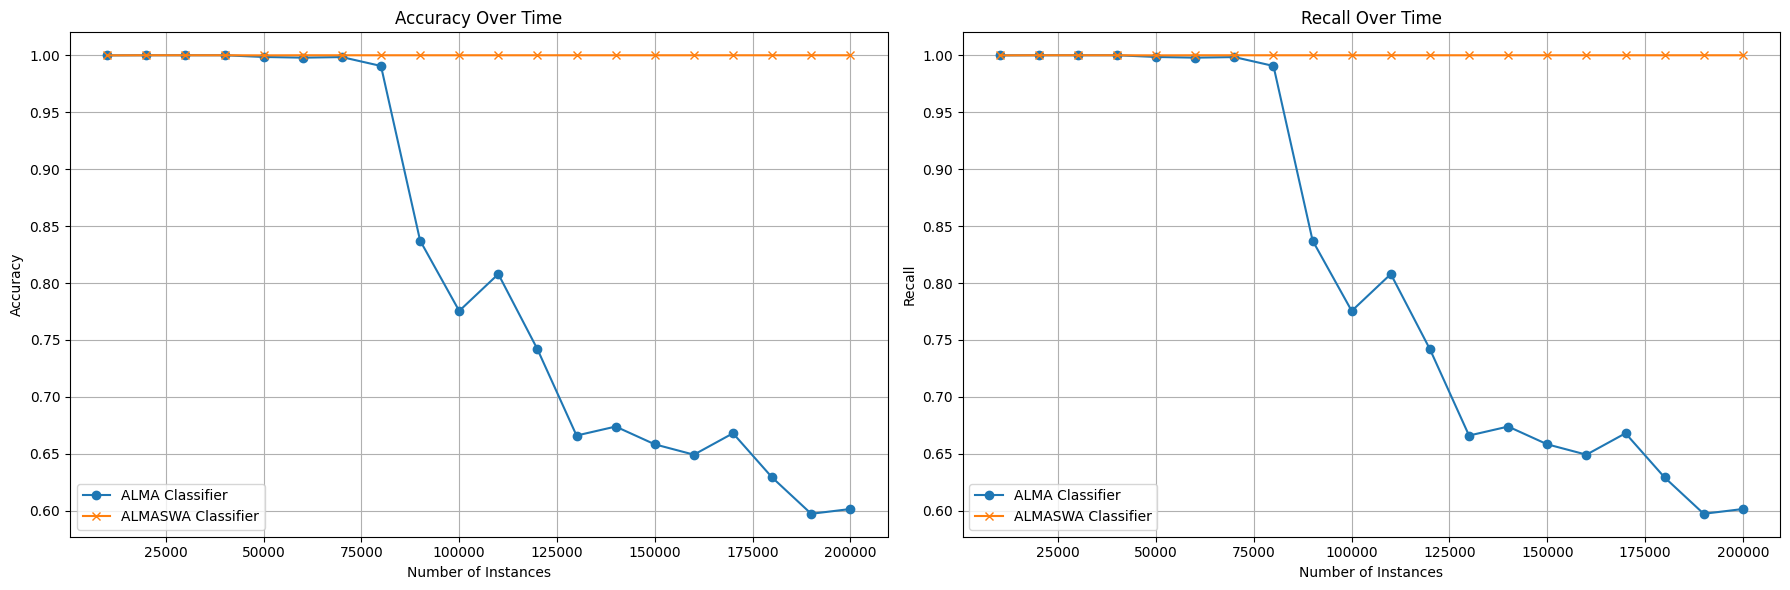

In [19]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import deque
from river import metrics
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")

# Define feature columns and target
feature_columns = [col for col in data.columns if col not in ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label']]
X = data[feature_columns]
y = data['Label'] 

# Parameters for drift simulation
total_instances = 200000
drift_steps = 5
instances_per_drift = total_instances // drift_steps
initial_noise_std = 0.0
noise_increment = 0.10

def gradual_drift_stream(X, y, total_instances, drift_steps, instances_per_drift, 
                         noise_increment, feature_cols, target_col):
    """
    Generator that yields data instances with gradual concept drift.
    Noise is incrementally added to specified features every drift step.
    """
    current_noise_std = initial_noise_std
    for i in tqdm(range(total_instances), desc="Creating data stream"):
        if i > 0 and i % instances_per_drift == 0:
            current_noise_std += noise_increment
            print(f"\nDrift step {i // instances_per_drift}: Increasing noise_std to {current_noise_std:.2f}")
        
        # Apply noise to specified features
        instance = X.iloc[i].copy()
        instance["IN_BYTES"] += np.random.normal(0, current_noise_std * X["IN_BYTES"].std())
        instance["OUT_BYTES"] += np.random.normal(0, current_noise_std * X["OUT_BYTES"].std())
        
        label = y.iloc[i]
        yield instance.to_dict(), label

# Initialize classifiers
alma = linear_model.ALMAClassifier()
almaswa = ALMASWAClassifier()

# Metrics tracking
accuracy_alma = []
accuracy_almaswa = []
recall_alma = []
recall_almaswa = []
evaluation_points = []

window_size = 10000  # Sliding window size
slide_interval = 10000  # Evaluate every 10,000 instances

# Queues to store true labels and predictions
true_labels = deque(maxlen=window_size)
predictions_alma = deque(maxlen=window_size)
predictions_almaswa = deque(maxlen=window_size)

# Create the data stream
data_stream = gradual_drift_stream(
    X=X,
    y=y,
    total_instances=total_instances,
    drift_steps=drift_steps,
    instances_per_drift=instances_per_drift,
    noise_increment=noise_increment,
    feature_cols=feature_columns,
    target_col='Label'
)

# Iterate through the data stream
for i, (x, y_true) in enumerate(data_stream):
    # Make predictions before learning
    y_pred_alma = alma.predict_one(x)
    y_pred_almaswa = almaswa.predict_one(x)

    # Update the queues with true labels and predictions
    true_labels.append(y_true)
    predictions_alma.append(y_pred_alma)
    predictions_almaswa.append(y_pred_almaswa)

    # Learn from the current instance
    alma.learn_one(x, y_true)
    almaswa.learn_one(x, y_true)

    # Evaluate at each sliding window
    if (i + 1) % slide_interval == 0:
        # Initialize River's metrics
        acc_metric_alma = metrics.Accuracy()
        acc_metric_almaswa = metrics.Accuracy()
        rec_metric_alma = metrics.Recall()
        rec_metric_almaswa = metrics.Recall()

        # Update metrics for ALMA Classifier
        for true, pred in zip(true_labels, predictions_alma):
            acc_metric_alma.update(true, pred)
            rec_metric_alma.update(true, pred)
        
        # Update metrics for ALMASWA Classifier
        for true, pred in zip(true_labels, predictions_almaswa):
            acc_metric_almaswa.update(true, pred)
            rec_metric_almaswa.update(true, pred)

        # Append metrics
        evaluation_points.append(i + 1)
        accuracy_alma.append(acc_metric_alma.get())
        accuracy_almaswa.append(acc_metric_almaswa.get())
        recall_alma.append(rec_metric_alma.get())
        recall_almaswa.append(rec_metric_almaswa.get())

        # Print metrics
        print(f"\nEvaluation at instance {i + 1}:")
        print(f"ALMA - Accuracy: {acc_metric_alma.get():.4f}, Recall: {rec_metric_alma.get():.4f}")
        print(f"ALMASWA - Accuracy: {acc_metric_almaswa.get():.4f}, Recall: {rec_metric_almaswa.get():.4f}")

# Define the plotting function
def plot_metrics(evaluation_points, accuracy_alma, accuracy_almaswa, 
                rec_alma, rec_almaswa):
    plt.figure(figsize=(18, 6))

    # Plot Detection Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(evaluation_points, accuracy_alma, label='ALMA Classifier', marker='o')
    plt.plot(evaluation_points, accuracy_almaswa, label='ALMASWA Classifier', marker='x')
    plt.xlabel('Number of Instances')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()
    plt.grid(True)

    # Plot F1-Score
    plt.subplot(1, 2, 2)
    plt.plot(evaluation_points, recall_alma, label='ALMA Classifier', marker='o')
    plt.plot(evaluation_points, recall_almaswa, label='ALMASWA Classifier', marker='x')
    plt.xlabel('Number of Instances')
    plt.ylabel('Recall')
    plt.title('Recall Over Time')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/CSE_Gradual_Drift.png')
    plt.show()

# Plot the metrics
plot_metrics(evaluation_points, accuracy_alma, accuracy_almaswa, recall_alma, recall_almaswa)

# Experiment 4: Response to Sudden Concept Drift Events

Creating data stream:   5%|▋             | 10015/200000 [01:41<33:48, 93.65it/s]


Evaluation at instance 10000:
ALMA - Accuracy: 0.9999, Recall: 0.9999
ALMASWA - Accuracy: 0.9999, Recall: 0.9999

Baseline Accuracy (ALMA): 0.9999
Baseline Recall (ALMA): 0.9999
Baseline Accuracy (ALMASWA): 0.9999
Baseline Recall (ALMASWA): 0.9999


Creating data stream:  10%|█▍            | 20018/200000 [03:22<30:40, 97.81it/s]


Evaluation at instance 20000:
ALMA - Accuracy: 1.0000, Recall: 1.0000
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  15%|█▉           | 30014/200000 [05:00<27:26, 103.23it/s]


Evaluation at instance 30000:
ALMA - Accuracy: 1.0000, Recall: 1.0000
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  20%|██▌          | 40012/200000 [07:14<25:49, 103.24it/s]


Evaluation at instance 40000:
ALMA - Accuracy: 1.0000, Recall: 1.0000
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  25%|███▌          | 50012/200000 [08:49<25:06, 99.56it/s]


Evaluation at instance 50000:
ALMA - Accuracy: 1.0000, Recall: 1.0000
ALMASWA - Accuracy: 1.0000, Recall: 1.0000
ALMA recovered at instance 50000
ALMASWA recovered at instance 50000

Sudden drift introduced at instance 50000


Creating data stream:  30%|███▉         | 60022/200000 [10:17<17:53, 130.35it/s]


Evaluation at instance 60000:
ALMA - Accuracy: 0.9971, Recall: 0.9985
ALMASWA - Accuracy: 0.9990, Recall: 0.9995


Creating data stream:  35%|████▌        | 70016/200000 [11:35<16:47, 129.07it/s]


Evaluation at instance 70000:
ALMA - Accuracy: 0.9957, Recall: 0.9978
ALMASWA - Accuracy: 0.9999, Recall: 0.9999


Creating data stream:  40%|█████▏       | 80016/200000 [12:50<15:31, 128.78it/s]


Evaluation at instance 80000:
ALMA - Accuracy: 0.9878, Recall: 0.9939
ALMASWA - Accuracy: 0.9950, Recall: 0.9975


Creating data stream:  45%|█████▊       | 90021/200000 [14:04<14:14, 128.68it/s]


Evaluation at instance 90000:
ALMA - Accuracy: 0.5738, Recall: 0.7292
ALMASWA - Accuracy: 0.9632, Recall: 0.9813


Creating data stream:  50%|██████      | 100029/200000 [15:22<11:40, 142.67it/s]


Evaluation at instance 100000:
ALMA - Accuracy: 0.5474, Recall: 0.7075
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  55%|██████▌     | 110018/200000 [16:26<09:31, 157.39it/s]


Evaluation at instance 110000:
ALMA - Accuracy: 0.5488, Recall: 0.7087
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  60%|███████▏    | 120022/200000 [17:27<08:38, 154.30it/s]


Evaluation at instance 120000:
ALMA - Accuracy: 0.5533, Recall: 0.7124
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  65%|███████▊    | 130016/200000 [18:29<07:52, 148.13it/s]


Evaluation at instance 130000:
ALMA - Accuracy: 0.5296, Recall: 0.6925
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  70%|████████▍   | 140032/200000 [19:31<06:19, 157.82it/s]


Evaluation at instance 140000:
ALMA - Accuracy: 0.5640, Recall: 0.7212
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  75%|█████████   | 150022/200000 [20:32<05:14, 159.07it/s]


Evaluation at instance 150000:
ALMA - Accuracy: 0.5552, Recall: 0.7140
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  80%|█████████▌  | 160029/200000 [21:34<04:03, 163.91it/s]


Evaluation at instance 160000:
ALMA - Accuracy: 0.5304, Recall: 0.6932
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  85%|██████████▏ | 170016/200000 [22:36<03:18, 151.09it/s]


Evaluation at instance 170000:
ALMA - Accuracy: 0.5485, Recall: 0.7084
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  90%|██████████▊ | 180022/200000 [23:38<02:05, 158.78it/s]


Evaluation at instance 180000:
ALMA - Accuracy: 0.5598, Recall: 0.7178
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream:  95%|███████████▍| 190026/200000 [24:41<01:02, 158.61it/s]


Evaluation at instance 190000:
ALMA - Accuracy: 0.5340, Recall: 0.6962
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


Creating data stream: 100%|████████████| 200000/200000 [25:43<00:00, 129.56it/s]



Evaluation at instance 200000:
ALMA - Accuracy: 0.5581, Recall: 0.7164
ALMASWA - Accuracy: 1.0000, Recall: 1.0000


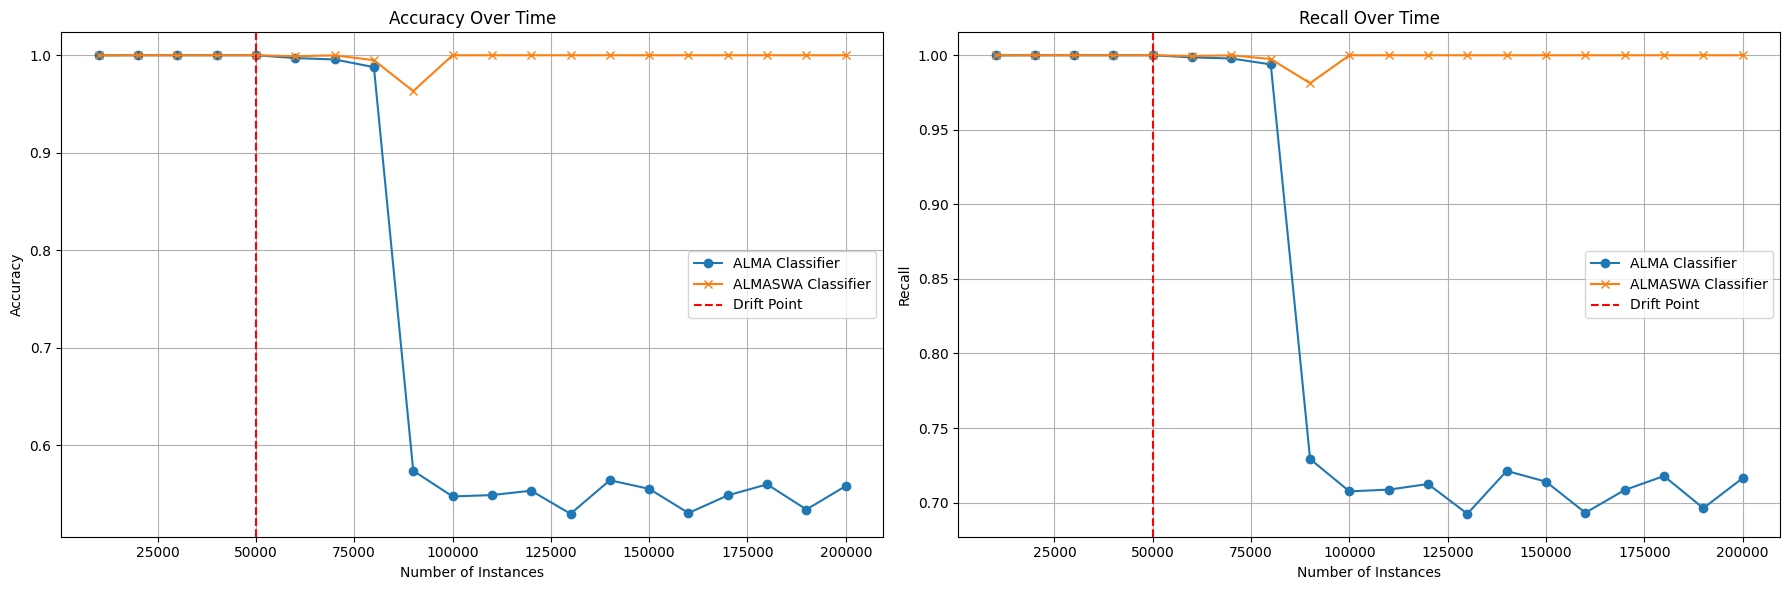

In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import deque
from river import metrics
import matplotlib.pyplot as plt

# ------------------------------
# Load and Prepare the Dataset
# ------------------------------

# Load the dataset
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")

# Define feature columns and target
feature_columns = [col for col in data.columns if col not in ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label']]
X = data[feature_columns]
y = data['Label']  # Assuming 'Label' is the target variable

# ------------------------------
# Parameters for Drift Simulation
# ------------------------------

total_instances = 200000
drift_point = 50000  # Instance at which sudden drift occurs
noise_before_drift = 0.0
noise_after_drift = 0.8  # Increased noise to simulate sudden drift
noise_increment = 0.0  # Not used in sudden drift

# ------------------------------
# Data Stream Generator with Sudden Drift
# ------------------------------

def sudden_drift_stream(X, y, total_instances, drift_point, 
                        noise_before, noise_after, feature_cols, target_col):
    """
    Generator that yields data instances with a sudden concept drift.
    Noise is added to specified features at the drift point.
    """
    for i in tqdm(range(total_instances), desc="Creating data stream"):
        if i == drift_point:
            print(f"\nSudden drift introduced at instance {i}")
            current_noise_std = noise_after
        elif i < drift_point:
            current_noise_std = noise_before
        # After drift point, use increased noise
        else:
            current_noise_std = noise_after
        
        # Apply noise to specified features
        instance = X.iloc[i].copy()
        instance["IN_BYTES"] += np.random.normal(0, current_noise_std * X["IN_BYTES"].std())
        instance["OUT_BYTES"] += np.random.normal(0, current_noise_std * X["OUT_BYTES"].std())
        
        label = y.iloc[i]
        yield instance.to_dict(), label

# Initialize classifiers
alma = linear_model.ALMAClassifier()
almaswa = ALMASWAClassifier()

# ------------------------------
# Metrics Tracking Initialization
# ------------------------------

accuracy_alma = []
accuracy_almaswa = []
recall_alma = []
recall_almaswa = []
evaluation_points = []

window_size = 10000  # Sliding window size
slide_interval = 10000  # Evaluate every 10,000 instances

# Queues to store true labels and predictions
true_labels = deque(maxlen=window_size)
predictions_alma = deque(maxlen=window_size)
predictions_almaswa = deque(maxlen=window_size)

# Detection Delay Tracking
# Define baseline metrics before drift
baseline_accuracy = None
baseline_recall = None

# Threshold to consider recovery (95% of baseline)
recovery_threshold = 0.95

# Flags and counters
alma_recovered = False
almaswa_recovered = False
alma_recovery_point = None
almaswa_recovery_point = None

# ------------------------------
# Create the Data Stream
# ------------------------------

data_stream = sudden_drift_stream(
    X=X,
    y=y,
    total_instances=total_instances,
    drift_point=drift_point,
    noise_before=noise_before_drift,
    noise_after=noise_after_drift,
    feature_cols=feature_columns,
    target_col='Label'
)

# ------------------------------
# Iterate Through the Data Stream
# ------------------------------

for i, (x, y_true) in enumerate(data_stream):
    # Make predictions before learning
    y_pred_alma = alma.predict_one(x)
    y_pred_almaswa = almaswa.predict_one(x)

    # Update the queues with true labels and predictions
    true_labels.append(y_true)
    predictions_alma.append(y_pred_alma)
    predictions_almaswa.append(y_pred_almaswa)

    # Learn from the current instance
    alma.learn_one(x, y_true)
    almaswa.learn_one(x, y_true)

    # Evaluate at each sliding window
    if (i + 1) % slide_interval == 0:
        # Initialize River's metrics
        acc_metric_alma = metrics.Accuracy()
        acc_metric_almaswa = metrics.Accuracy()
        rec_metric_alma = metrics.F1()
        rec_metric_almaswa = metrics.F1()

        # Update metrics for ALMA Classifier
        for true, pred in zip(true_labels, predictions_alma):
            acc_metric_alma.update(true, pred)
            rec_metric_alma.update(true, pred)
        
        # Update metrics for ALMASWA Classifier
        for true, pred in zip(true_labels, predictions_almaswa):
            acc_metric_almaswa.update(true, pred)
            rec_metric_almaswa.update(true, pred)

        # Append metrics
        evaluation_points.append(i + 1)
        accuracy_alma.append(acc_metric_alma.get())
        accuracy_almaswa.append(acc_metric_almaswa.get())
        recall_alma.append(rec_metric_alma.get())
        recall_almaswa.append(rec_metric_almaswa.get())

        # Print metrics
        print(f"\nEvaluation at instance {i + 1}:")
        print(f"ALMA - Accuracy: {acc_metric_alma.get():.4f}, Recall: {rec_metric_alma.get():.4f}")
        print(f"ALMASWA - Accuracy: {acc_metric_almaswa.get():.4f}, Recall: {rec_metric_almaswa.get():.4f}")

        # Set baseline metrics before drift (first window before drift)
        if i + 1 == window_size and i + 1 < drift_point:
            baseline_accuracy = acc_metric_alma.get()
            baseline_recall = rec_metric_alma.get()
            print(f"\nBaseline Accuracy (ALMA): {baseline_accuracy:.4f}")
            print(f"Baseline Recall (ALMA): {baseline_recall:.4f}")
            baseline_accuracy_almaswa = acc_metric_almaswa.get()
            baseline_recall_almaswa = rec_metric_almaswa.get()
            print(f"Baseline Accuracy (ALMASWA): {baseline_accuracy_almaswa:.4f}")
            print(f"Baseline Recall (ALMASWA): {baseline_recall_almaswa:.4f}")

        # After drift, check for recovery
        if i + 1 >= drift_point:
            # ALMA Recovery Check
            if not alma_recovered and baseline_accuracy is not None:
                if acc_metric_alma.get() >= recovery_threshold * baseline_accuracy:
                    alma_recovered = True
                    alma_recovery_point = i + 1
                    print(f"ALMA recovered at instance {i + 1}")
            
            # ALMASWA Recovery Check
            if not almaswa_recovered and baseline_accuracy_almaswa is not None:
                if acc_metric_almaswa.get() >= recovery_threshold * baseline_accuracy_almaswa:
                    almaswa_recovered = True
                    almaswa_recovery_point = i + 1
                    print(f"ALMASWA recovered at instance {i + 1}")

# ------------------------------
# Define the Plotting Function
# ------------------------------

def plot_metrics(evaluation_points, accuracy_alma, accuracy_almaswa, 
                recall_alma, recall_almaswa, drift_point, alma_recovery, almaswa_recovery):
    plt.figure(figsize=(18, 6))

    # Plot Detection Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(evaluation_points, accuracy_alma, label='ALMA Classifier', marker='o')
    plt.plot(evaluation_points, accuracy_almaswa, label='ALMASWA Classifier', marker='x')
    plt.axvline(x=drift_point, color='r', linestyle='--', label='Drift Point')
    #if alma_recovery:
        #plt.axvline(x=alma_recovery, color='g', linestyle=':', label='ALMA Recovery')
    #if almaswa_recovery:
        #plt.axvline(x=almaswa_recovery, color='b', linestyle=':', label='ALMASWA Recovery')
    plt.xlabel('Number of Instances')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()
    plt.grid(True)

    # Plot F1-Score
    plt.subplot(1, 2, 2)
    plt.plot(evaluation_points, recall_alma, label='ALMA Classifier', marker='o')
    plt.plot(evaluation_points, recall_almaswa, label='ALMASWA Classifier', marker='x')
    plt.axvline(x=drift_point, color='r', linestyle='--', label='Drift Point')
    #if alma_recovery:
        #plt.axvline(x=alma_recovery, color='g', linestyle=':', label='ALMA Recovery')
    #if almaswa_recovery:
        #plt.axvline(x=almaswa_recovery, color='b', linestyle=':', label='ALMASWA Recovery')
    plt.xlabel('Number of Instances')
    plt.ylabel('Recall')
    plt.title('Recall Over Time')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/CSE_Sudden_Drift.png')
    plt.show()

# ------------------------------
# Plot the Metrics
# ------------------------------

plot_metrics(
    evaluation_points, 
    accuracy_alma, 
    accuracy_almaswa, 
    recall_alma, 
    recall_almaswa, 
    drift_point=drift_point, 
    alma_recovery=alma_recovery_point, 
    almaswa_recovery=almaswa_recovery_point
)

## Experiment 5: Paired t-test using different seeds

In [13]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle

from river import stream
from river import metrics

# Optional: for significance testing
# e.g., SciPy's paired t-test
from scipy.stats import ttest_rel

# 1. Load the data once (we'll shuffle with different seeds in each run)
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")

# Separate features (X) and label (y)
X_full = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y_full = data['Label']

# 2. We'll run 10 experiments, each with a different random seed
NUM_RUNS = 5
seeds = range(NUM_RUNS)  # e.g., 0 through 9

# We'll store final accuracy for each run
alma_accuracies = []
almaswa_accuracies = []

for seed in seeds:
    print(f"Running experiment with seed={seed} ...")
    
    # 2a. Shuffle data with this seed
    X, y = shuffle(X_full, y_full, random_state=seed)
    
    # 2b. Convert to a River stream
    data_stream = stream.iter_pandas(X, y)
    
    # 2c. Instantiate models & metrics
    model_alma = linear_model.ALMAClassifier()
    model_almaswa = ALMASWAClassifier()
    
    metric_alma = metrics.Accuracy()
    metric_almaswa = metrics.Accuracy()
    
    # 2d. Progressive learning/evaluation
    for x_dict, y_true in data_stream:
        # ALMA
        y_pred_alma = model_alma.predict_one(x_dict)
        metric_alma.update(y_true, y_pred_alma)
        model_alma.learn_one(x_dict, y_true)
        
        # ALMA+SWA
        y_pred_almaswa = model_almaswa.predict_one(x_dict)
        metric_almaswa.update(y_true, y_pred_almaswa)
        model_almaswa.learn_one(x_dict, y_true)
    
    # 2e. Collect final accuracies for this run
    alma_accuracies.append(metric_alma.get())
    almaswa_accuracies.append(metric_almaswa.get())
    
    print(f"  ALMA accuracy: {metric_alma.get():.4f}")
    print(f"  ALMA+SWA accuracy: {metric_almaswa.get():.4f}")
    print("")

# 3. Print summary of results
print("=== Summary of 10 Runs ===")
print("ALMA Accuracies   :", alma_accuracies)
print("ALMASWA Accuracies:", almaswa_accuracies)

print("\nMean ± Std for ALMA      : "
      f"{np.mean(alma_accuracies):.4f} ± {np.std(alma_accuracies):.4f}")
print("Mean ± Std for ALMA+SWA : "
      f"{np.mean(almaswa_accuracies):.4f} ± {np.std(almaswa_accuracies):.4f}")

# 4. (Optional) Significance test
#    Paired t-test over the 10 runs
t_stat, p_val = ttest_rel(alma_accuracies, almaswa_accuracies)
print(f"\nPaired t-test (ALMA vs ALMA+SWA): t_stat={t_stat:.4f}, p-value={p_val:.6f}")
if p_val <= 0.05:
    print("=> Statistically significant difference at alpha=0.05")
else:
    print("=> No statistically significant difference at alpha=0.05")

Running experiment with seed=0 ...
  ALMA accuracy: 0.9455
  ALMA+SWA accuracy: 0.9968

Running experiment with seed=1 ...
  ALMA accuracy: 0.9451
  ALMA+SWA accuracy: 0.9969

Running experiment with seed=2 ...
  ALMA accuracy: 0.9450
  ALMA+SWA accuracy: 0.9969

Running experiment with seed=3 ...
  ALMA accuracy: 0.9452
  ALMA+SWA accuracy: 0.9969

Running experiment with seed=4 ...
  ALMA accuracy: 0.9445
  ALMA+SWA accuracy: 0.9968

Running experiment with seed=5 ...
  ALMA accuracy: 0.9455
  ALMA+SWA accuracy: 0.9968

Running experiment with seed=6 ...
  ALMA accuracy: 0.9441
  ALMA+SWA accuracy: 0.9968

Running experiment with seed=7 ...
  ALMA accuracy: 0.9456
  ALMA+SWA accuracy: 0.9969

Running experiment with seed=8 ...
  ALMA accuracy: 0.9454
  ALMA+SWA accuracy: 0.9968

Running experiment with seed=9 ...
  ALMA accuracy: 0.9457
  ALMA+SWA accuracy: 0.9968

=== Summary of 10 Runs ===
ALMA Accuracies   : [0.945454935342382, 0.9451439997927097, 0.9449501118206438, 0.94517437855

## Experiment 7: Measuring Resource Usage

Number of samples per class: Counter({1: 1019203, 0: 100000})
Processed 100000 samples. Throughput: 12430.01 samples/sec.
Processed 200000 samples. Throughput: 13185.10 samples/sec.
Processed 300000 samples. Throughput: 13429.86 samples/sec.
Processed 400000 samples. Throughput: 13571.17 samples/sec.
Processed 500000 samples. Throughput: 13649.14 samples/sec.
Processed 600000 samples. Throughput: 13705.69 samples/sec.
Processed 700000 samples. Throughput: 13747.30 samples/sec.
Processed 800000 samples. Throughput: 13783.95 samples/sec.
Processed 900000 samples. Throughput: 13750.31 samples/sec.
Processed 1000000 samples. Throughput: 13737.45 samples/sec.
Processed 1100000 samples. Throughput: 2393.91 samples/sec.

Total samples processed: 1119203
Total elapsed time: 461.19 seconds
Throughput: 2426.78 samples/second

--- ALMAClassifier ---
Accuracy: 0.9913
F1 Score: 0.9952
ROCAUC Score: 0.9889

--- ALMASWAClassifier ---
Accuracy: 0.9981
F1 Score: 0.9990
ROCAUC Score: 0.9916

--- ALMACla

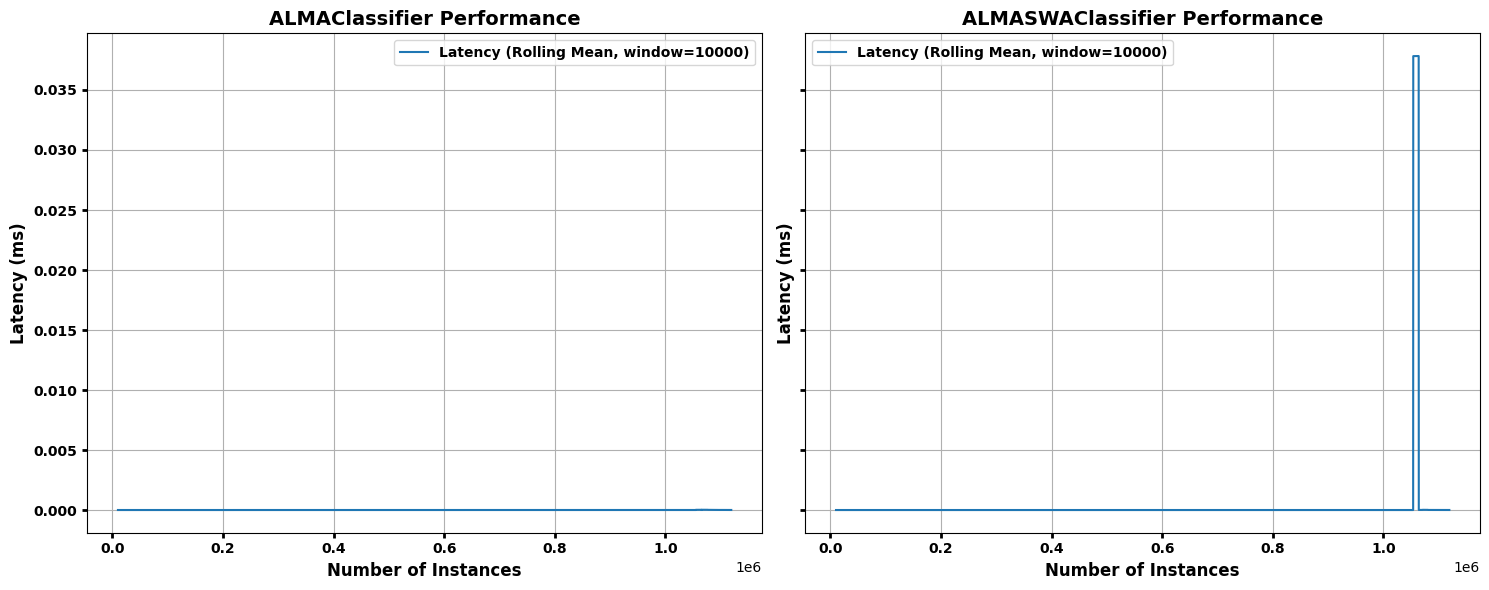

In [14]:
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle
from river import compose, preprocessing, linear_model, metrics, stream
import time
import psutil
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Initialize Classifiers and Metrics
# ---------------------------

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()  # Ensure ALMASWAClassifier is correctly imported or defined
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'F1': metrics.F1(),
        'ROCAUC': metrics.ROCAUC()
    }
    for name in classifiers
}

# Initialize performance tracking dictionaries
performance_metrics = {
    name: {
        'Latency': [],             # Time taken per sample (predict + learn)
        'Total_Time': [],          # Cumulative processing time per sample
        'CPU_Usage': [],           # CPU usage in percentage
        'Memory_Usage': []         # Memory usage in KB (Modified from MB to KB)
    }
    for name in classifiers
}

# Initialize overall tracking variables
total_samples = 0
start_time = time.time()

# Initialize psutil process for monitoring
process = psutil.Process()

# ---------------------------
# Step 2: Load and Prepare Data
# ---------------------------

# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")
print('Number of samples per class:', Counter(data['Label']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# ---------------------------
# Step 3: Training Loop with Performance Measurement
# ---------------------------

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    total_samples += 1
    sample_start_time = time.time()

    # Get current CPU and memory usage before processing
    cpu_before = process.cpu_percent(interval=None)
    memory_before = process.memory_info().rss / 1024  # Convert to KB (Modified)

    for name, model in classifiers.items():
        clf_start_time = time.time()

        # Predict
        y_pred = model.predict_one(x)

        # Learn
        model.learn_one(x, true_y)

        # Calculate latency for this classifier
        clf_latency = time.time() - clf_start_time

        # Update metrics
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['F1'].update(true_y, y_pred)
        metrics_dict[name]['ROCAUC'].update(true_y, y_pred)

        # Record latency
        performance_metrics[name]['Latency'].append(clf_latency)

    # Get current CPU and memory usage after processing
    cpu_after = process.cpu_percent(interval=None)
    memory_after = process.memory_info().rss / 1024  # Convert to KB (Modified)

    # Calculate CPU and memory usage during processing
    cpu_usage = cpu_after - cpu_before
    memory_usage = memory_after - memory_before

    # Record CPU and memory usage for each classifier (approximate)
    for name in classifiers.keys():
        performance_metrics[name]['CPU_Usage'].append(cpu_usage / len(classifiers))
        performance_metrics[name]['Memory_Usage'].append(memory_usage / len(classifiers))

    # Calculate total processing time for this sample
    total_time = time.time() - sample_start_time
    for name in classifiers.keys():
        performance_metrics[name]['Total_Time'].append(total_time / len(classifiers))

    # Optional: Print progress every 100,000 samples
    if (i + 1) % 100000 == 0:
        elapsed_time = time.time() - start_time
        throughput = total_samples / elapsed_time
        print(f'Processed {i + 1} samples. Throughput: {throughput:.2f} samples/sec.')

# ---------------------------
# Step 4: Calculate Throughput
# ---------------------------

# Calculate total elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Calculate throughput (samples per second)
throughput = total_samples / elapsed_time
print(f'\nTotal samples processed: {total_samples}')
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
print(f'Throughput: {throughput:.2f} samples/second\n')

# ---------------------------
# Step 5: Display Results
# ---------------------------

# Display classification metrics
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"F1 Score: {metric['F1'].get():.4f}")
    print(f"ROCAUC Score: {metric['ROCAUC'].get():.4f}\n")

# Display performance metrics summary
for name, metrics_perf in performance_metrics.items():
    avg_latency = sum(metrics_perf['Latency']) / len(metrics_perf['Latency']) if metrics_perf['Latency'] else 0
    avg_cpu = sum(metrics_perf['CPU_Usage']) / len(metrics_perf['CPU_Usage']) if metrics_perf['CPU_Usage'] else 0
    avg_memory = sum(metrics_perf['Memory_Usage']) / len(metrics_perf['Memory_Usage']) if metrics_perf['Memory_Usage'] else 0
    avg_total_time = sum(metrics_perf['Total_Time']) / len(metrics_perf['Total_Time']) if metrics_perf['Total_Time'] else 0

    print(f'--- {name} Performance ---')
    print(f"Average Latency per Sample: {avg_latency * 1000:.4f} ms")
    print(f"Average CPU Usage: {avg_cpu:.2f}%")
    print(f"Average Memory Usage: {avg_memory:.2f} KB")  # Modified to KB
    print(f"Average Total Processing Time per Sample: {avg_total_time * 1000:.4f} ms\n")

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# Enhanced Plotting Function to handle multiple classifiers side by side
def plot_performance_side_by_side(performance_metrics, classifier_names, window_size=10000):
    metrics_names = ['Latency']
    num_classifiers = len(classifier_names)
    
    # Create subplots arranged side by side with shared y-axis
    fig, axes = plt.subplots(1, num_classifiers, figsize=(15, 6), sharey=True)
    
    # If there's only one classifier, axes might not be a list
    if num_classifiers == 1:
        axes = [axes]
    
    for ax, classifier_name in zip(axes, classifier_names):
        for metric in metrics_names:
            metric_series = pd.Series(performance_metrics[classifier_name][metric])
            rolling_metric = metric_series.rolling(window=window_size).mean()
            ax.plot(rolling_metric, label=f'{metric} (Rolling Mean, window={window_size})')
        
        # Set titles and labels with bold font
        ax.set_title(f'{classifier_name} Performance', fontweight='bold', fontsize=14)
        ax.set_xlabel('Number of Instances', fontweight='bold', fontsize=12)
        ax.set_ylabel('Latency (ms)', fontweight='bold', fontsize=12)
        
        # Make ticks bold
        ax.tick_params(axis='both', which='major', labelsize=10, width=2)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        
        # Make legend bold using prop
        ax.legend(prop={'weight': 'bold'})
        ax.grid(True)

    # Force y-axis tick labels to be bold on all subplots
    for ax in axes:
        for tick in ax.yaxis.get_ticklabels():
            tick.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/CSE_Latency.png')
    plt.show()

# Example: Plot performance metrics for both classifiers side by side
plot_performance_side_by_side(performance_metrics, ['ALMAClassifier', 'ALMASWAClassifier'])

### CPU Usage

Number of samples per class: Counter({1: 1019203, 0: 100000})
Processed 100000 samples. Throughput: 11484.35 samples/sec.
Processed 200000 samples. Throughput: 12487.23 samples/sec.
Processed 300000 samples. Throughput: 12906.87 samples/sec.
Processed 400000 samples. Throughput: 13120.27 samples/sec.
Processed 500000 samples. Throughput: 13251.46 samples/sec.
Processed 600000 samples. Throughput: 13359.16 samples/sec.
Processed 700000 samples. Throughput: 13438.22 samples/sec.
Processed 800000 samples. Throughput: 13460.86 samples/sec.
Processed 900000 samples. Throughput: 13504.93 samples/sec.
Processed 1000000 samples. Throughput: 13437.76 samples/sec.
Processed 1100000 samples. Throughput: 13429.77 samples/sec.

Total samples processed: 1119203
Total elapsed time: 83.44 seconds
Throughput: 13412.76 samples/second

--- ALMAClassifier ---
Accuracy: 0.9913
F1 Score: 0.9952
ROCAUC Score: 0.9889

--- ALMASWAClassifier ---
Accuracy: 0.9981
F1 Score: 0.9990
ROCAUC Score: 0.9916

--- ALMACl

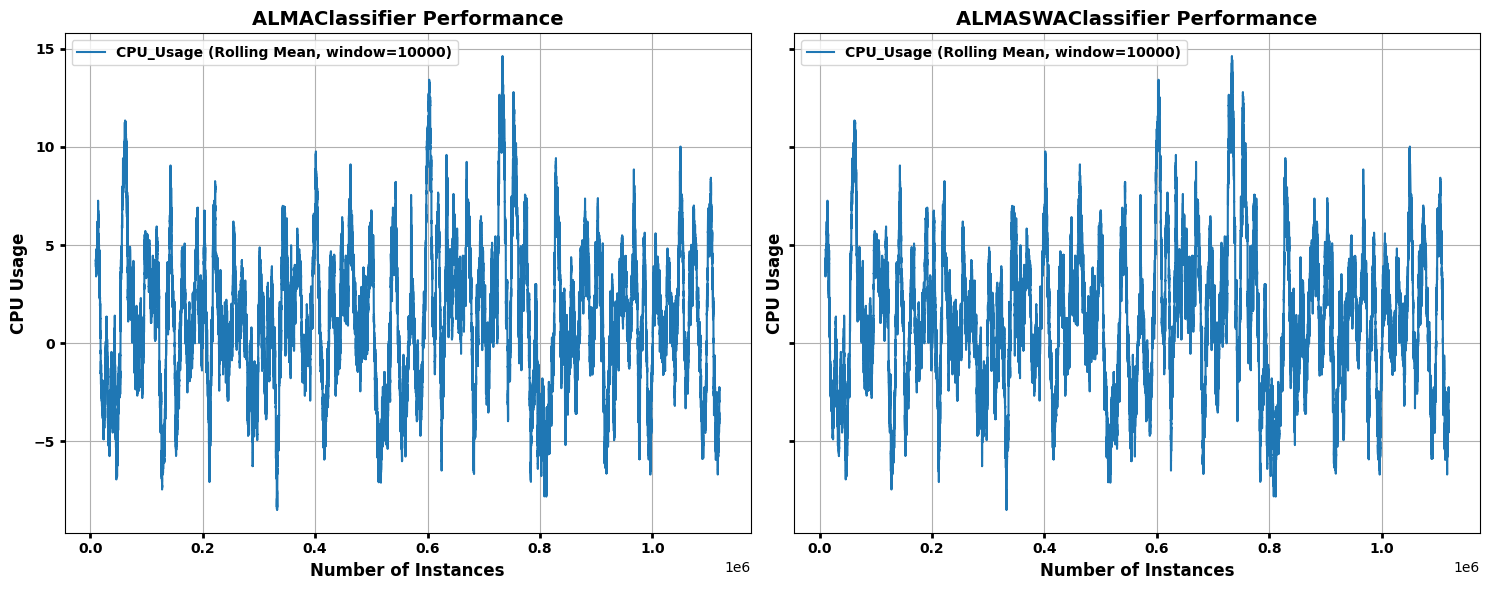

In [15]:
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle
from river import compose, preprocessing, linear_model, metrics, stream
import time
import psutil
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Initialize Classifiers and Metrics
# ---------------------------

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()  # Ensure ALMASWAClassifier is correctly imported or defined
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'F1': metrics.F1(),
        'ROCAUC': metrics.ROCAUC()
    }
    for name in classifiers
}

# Initialize performance tracking dictionaries
performance_metrics = {
    name: {
        'Latency': [],             # Time taken per sample (predict + learn)
        'Total_Time': [],          # Cumulative processing time per sample
        'CPU_Usage': [],           # CPU usage in percentage
        'Memory_Usage': []         # Memory usage in KB (Modified from MB to KB)
    }
    for name in classifiers
}

# Initialize overall tracking variables
total_samples = 0
start_time = time.time()

# Initialize psutil process for monitoring
process = psutil.Process()

# ---------------------------
# Step 2: Load and Prepare Data
# ---------------------------

# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")
print('Number of samples per class:', Counter(data['Label']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# ---------------------------
# Step 3: Training Loop with Performance Measurement
# ---------------------------

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    total_samples += 1
    sample_start_time = time.time()

    # Get current CPU and memory usage before processing
    cpu_before = process.cpu_percent(interval=None)
    memory_before = process.memory_info().rss / 1024  # Convert to KB (Modified)

    for name, model in classifiers.items():
        clf_start_time = time.time()

        # Predict
        y_pred = model.predict_one(x)

        # Learn
        model.learn_one(x, true_y)

        # Calculate latency for this classifier
        clf_latency = time.time() - clf_start_time

        # Update metrics
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['F1'].update(true_y, y_pred)
        metrics_dict[name]['ROCAUC'].update(true_y, y_pred)

        # Record latency
        performance_metrics[name]['Latency'].append(clf_latency)

    # Get current CPU and memory usage after processing
    cpu_after = process.cpu_percent(interval=None)
    memory_after = process.memory_info().rss / 1024  # Convert to KB (Modified)

    # Calculate CPU and memory usage during processing
    cpu_usage = cpu_after - cpu_before
    memory_usage = memory_after - memory_before

    # Record CPU and memory usage for each classifier (approximate)
    for name in classifiers.keys():
        performance_metrics[name]['CPU_Usage'].append(cpu_usage / len(classifiers))
        performance_metrics[name]['Memory_Usage'].append(memory_usage / len(classifiers))

    # Calculate total processing time for this sample
    total_time = time.time() - sample_start_time
    for name in classifiers.keys():
        performance_metrics[name]['Total_Time'].append(total_time / len(classifiers))

    # Optional: Print progress every 100,000 samples
    if (i + 1) % 100000 == 0:
        elapsed_time = time.time() - start_time
        throughput = total_samples / elapsed_time
        print(f'Processed {i + 1} samples. Throughput: {throughput:.2f} samples/sec.')

# ---------------------------
# Step 4: Calculate Throughput
# ---------------------------

# Calculate total elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Calculate throughput (samples per second)
throughput = total_samples / elapsed_time
print(f'\nTotal samples processed: {total_samples}')
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
print(f'Throughput: {throughput:.2f} samples/second\n')

# ---------------------------
# Step 5: Display Results
# ---------------------------

# Display classification metrics
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"F1 Score: {metric['F1'].get():.4f}")
    print(f"ROCAUC Score: {metric['ROCAUC'].get():.4f}\n")

# Display performance metrics summary
for name, metrics_perf in performance_metrics.items():
    avg_latency = sum(metrics_perf['Latency']) / len(metrics_perf['Latency']) if metrics_perf['Latency'] else 0
    avg_cpu = sum(metrics_perf['CPU_Usage']) / len(metrics_perf['CPU_Usage']) if metrics_perf['CPU_Usage'] else 0
    avg_memory = sum(metrics_perf['Memory_Usage']) / len(metrics_perf['Memory_Usage']) if metrics_perf['Memory_Usage'] else 0
    avg_total_time = sum(metrics_perf['Total_Time']) / len(metrics_perf['Total_Time']) if metrics_perf['Total_Time'] else 0

    print(f'--- {name} Performance ---')
    print(f"Average Latency per Sample: {avg_latency * 1000:.4f} ms")
    print(f"Average CPU Usage: {avg_cpu:.2f}%")
    print(f"Average Memory Usage: {avg_memory:.2f} KB")  # Modified to KB
    print(f"Average Total Processing Time per Sample: {avg_total_time * 1000:.4f} ms\n")

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# Enhanced Plotting Function to handle multiple classifiers side by side
def plot_performance_side_by_side(performance_metrics, classifier_names, window_size=10000):
    metrics_names = ['CPU_Usage']
    num_classifiers = len(classifier_names)
    
    # Create subplots arranged side by side with shared y-axis
    fig, axes = plt.subplots(1, num_classifiers, figsize=(15, 6), sharey=True)
    
    # If there's only one classifier, axes might not be a list
    if num_classifiers == 1:
        axes = [axes]
    
    for ax, classifier_name in zip(axes, classifier_names):
        for metric in metrics_names:
            metric_series = pd.Series(performance_metrics[classifier_name][metric])
            rolling_metric = metric_series.rolling(window=window_size).mean()
            ax.plot(rolling_metric, label=f'{metric} (Rolling Mean, window={window_size})')
        
        # Set titles and labels with bold font
        ax.set_title(f'{classifier_name} Performance', fontweight='bold', fontsize=14)
        ax.set_xlabel('Number of Instances', fontweight='bold', fontsize=12)
        ax.set_ylabel('CPU Usage', fontweight='bold', fontsize=12)
        
        # Make ticks bold
        ax.tick_params(axis='both', which='major', labelsize=10, width=2)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        
        # Make legend bold using prop
        ax.legend(prop={'weight': 'bold'})
        ax.grid(True)

    # Force y-axis tick labels to be bold on all subplots
    for ax in axes:
        for tick in ax.yaxis.get_ticklabels():
            tick.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/CSE_CPU.png')
    plt.show()

# Example: Plot performance metrics for both classifiers side by side
plot_performance_side_by_side(performance_metrics, ['ALMAClassifier', 'ALMASWAClassifier'])

### Memory usage

Number of samples per class: Counter({1: 1019203, 0: 100000})
Processed 100000 samples. Throughput: 11810.49 samples/sec.
Processed 200000 samples. Throughput: 12719.67 samples/sec.
Processed 300000 samples. Throughput: 13070.20 samples/sec.
Processed 400000 samples. Throughput: 13283.38 samples/sec.
Processed 500000 samples. Throughput: 13387.42 samples/sec.
Processed 600000 samples. Throughput: 13397.47 samples/sec.
Processed 700000 samples. Throughput: 13366.36 samples/sec.
Processed 800000 samples. Throughput: 13268.24 samples/sec.
Processed 900000 samples. Throughput: 13322.58 samples/sec.
Processed 1000000 samples. Throughput: 13337.70 samples/sec.
Processed 1100000 samples. Throughput: 13373.29 samples/sec.

Total samples processed: 1119203
Total elapsed time: 83.69 seconds
Throughput: 13373.73 samples/second

--- ALMAClassifier ---
Accuracy: 0.9913
F1 Score: 0.9952
ROCAUC Score: 0.9889

--- ALMASWAClassifier ---
Accuracy: 0.9981
F1 Score: 0.9990
ROCAUC Score: 0.9916

--- ALMACl

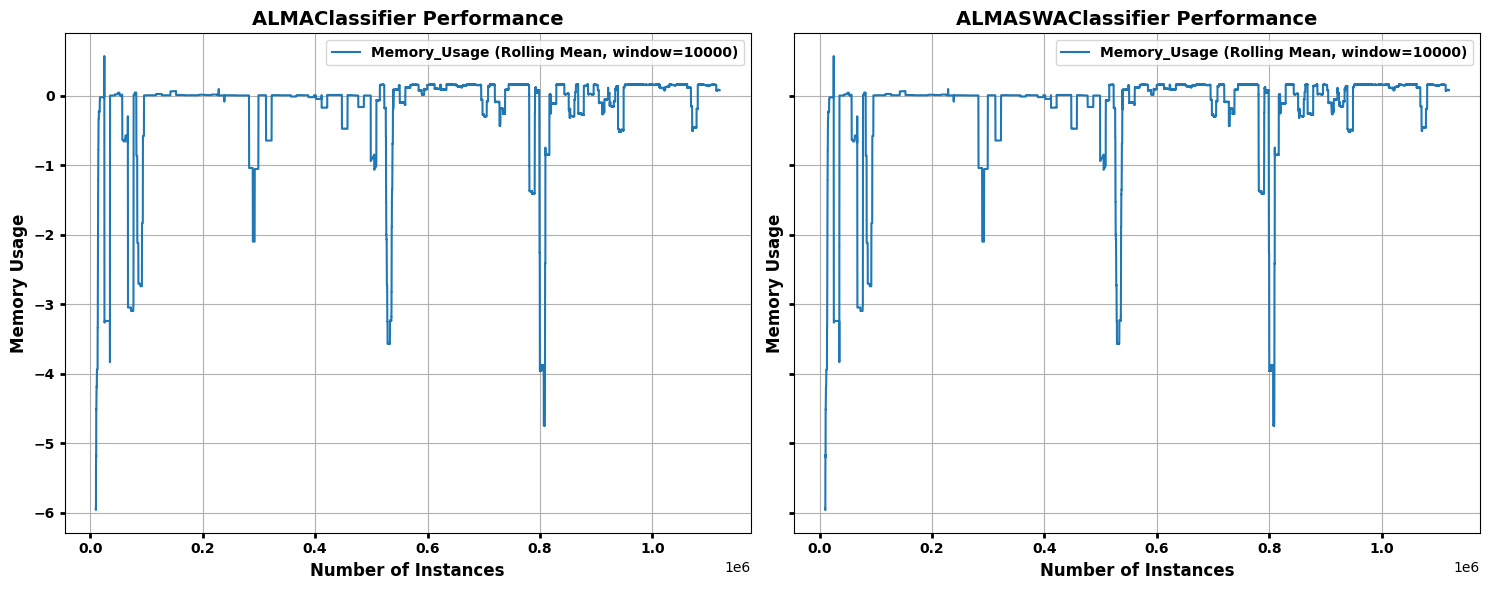

In [16]:
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle
from river import compose, preprocessing, linear_model, metrics, stream
import time
import psutil
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Initialize Classifiers and Metrics
# ---------------------------

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()  # Ensure ALMASWAClassifier is correctly imported or defined
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'F1': metrics.F1(),
        'ROCAUC': metrics.ROCAUC()
    }
    for name in classifiers
}

# Initialize performance tracking dictionaries
performance_metrics = {
    name: {
        'Latency': [],             # Time taken per sample (predict + learn)
        'Total_Time': [],          # Cumulative processing time per sample
        'CPU_Usage': [],           # CPU usage in percentage
        'Memory_Usage': []         # Memory usage in KB (Modified from MB to KB)
    }
    for name in classifiers
}

# Initialize overall tracking variables
total_samples = 0
start_time = time.time()

# Initialize psutil process for monitoring
process = psutil.Process()

# ---------------------------
# Step 2: Load and Prepare Data
# ---------------------------

# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")
print('Number of samples per class:', Counter(data['Label']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# ---------------------------
# Step 3: Training Loop with Performance Measurement
# ---------------------------

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    total_samples += 1
    sample_start_time = time.time()

    # Get current CPU and memory usage before processing
    cpu_before = process.cpu_percent(interval=None)
    memory_before = process.memory_info().rss / 1024  # Convert to KB (Modified)

    for name, model in classifiers.items():
        clf_start_time = time.time()

        # Predict
        y_pred = model.predict_one(x)

        # Learn
        model.learn_one(x, true_y)

        # Calculate latency for this classifier
        clf_latency = time.time() - clf_start_time

        # Update metrics
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['F1'].update(true_y, y_pred)
        metrics_dict[name]['ROCAUC'].update(true_y, y_pred)

        # Record latency
        performance_metrics[name]['Latency'].append(clf_latency)

    # Get current CPU and memory usage after processing
    cpu_after = process.cpu_percent(interval=None)
    memory_after = process.memory_info().rss / 1024  # Convert to KB (Modified)

    # Calculate CPU and memory usage during processing
    cpu_usage = cpu_after - cpu_before
    memory_usage = memory_after - memory_before

    # Record CPU and memory usage for each classifier (approximate)
    for name in classifiers.keys():
        performance_metrics[name]['CPU_Usage'].append(cpu_usage / len(classifiers))
        performance_metrics[name]['Memory_Usage'].append(memory_usage / len(classifiers))

    # Calculate total processing time for this sample
    total_time = time.time() - sample_start_time
    for name in classifiers.keys():
        performance_metrics[name]['Total_Time'].append(total_time / len(classifiers))

    # Optional: Print progress every 100,000 samples
    if (i + 1) % 100000 == 0:
        elapsed_time = time.time() - start_time
        throughput = total_samples / elapsed_time
        print(f'Processed {i + 1} samples. Throughput: {throughput:.2f} samples/sec.')

# ---------------------------
# Step 4: Calculate Throughput
# ---------------------------

# Calculate total elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Calculate throughput (samples per second)
throughput = total_samples / elapsed_time
print(f'\nTotal samples processed: {total_samples}')
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
print(f'Throughput: {throughput:.2f} samples/second\n')

# ---------------------------
# Step 5: Display Results
# ---------------------------

# Display classification metrics
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"F1 Score: {metric['F1'].get():.4f}")
    print(f"ROCAUC Score: {metric['ROCAUC'].get():.4f}\n")

# Display performance metrics summary
for name, metrics_perf in performance_metrics.items():
    avg_latency = sum(metrics_perf['Latency']) / len(metrics_perf['Latency']) if metrics_perf['Latency'] else 0
    avg_cpu = sum(metrics_perf['CPU_Usage']) / len(metrics_perf['CPU_Usage']) if metrics_perf['CPU_Usage'] else 0
    avg_memory = sum(metrics_perf['Memory_Usage']) / len(metrics_perf['Memory_Usage']) if metrics_perf['Memory_Usage'] else 0
    avg_total_time = sum(metrics_perf['Total_Time']) / len(metrics_perf['Total_Time']) if metrics_perf['Total_Time'] else 0

    print(f'--- {name} Performance ---')
    print(f"Average Latency per Sample: {avg_latency * 1000:.4f} ms")
    print(f"Average CPU Usage: {avg_cpu:.2f}%")
    print(f"Average Memory Usage: {avg_memory:.2f} KB")  # Modified to KB
    print(f"Average Total Processing Time per Sample: {avg_total_time * 1000:.4f} ms\n")

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# Enhanced Plotting Function to handle multiple classifiers side by side
def plot_performance_side_by_side(performance_metrics, classifier_names, window_size=10000):
    metrics_names = ['Memory_Usage']
    num_classifiers = len(classifier_names)
    
    # Create subplots arranged side by side with shared y-axis
    fig, axes = plt.subplots(1, num_classifiers, figsize=(15, 6), sharey=True)
    
    # If there's only one classifier, axes might not be a list
    if num_classifiers == 1:
        axes = [axes]
    
    for ax, classifier_name in zip(axes, classifier_names):
        for metric in metrics_names:
            metric_series = pd.Series(performance_metrics[classifier_name][metric])
            rolling_metric = metric_series.rolling(window=window_size).mean()
            ax.plot(rolling_metric, label=f'{metric} (Rolling Mean, window={window_size})')
        
        # Set titles and labels with bold font
        ax.set_title(f'{classifier_name} Performance', fontweight='bold', fontsize=14)
        ax.set_xlabel('Number of Instances', fontweight='bold', fontsize=12)
        ax.set_ylabel('Memory Usage', fontweight='bold', fontsize=12)
        
        # Make ticks bold
        ax.tick_params(axis='both', which='major', labelsize=10, width=2)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        
        # Make legend bold using prop
        ax.legend(prop={'weight': 'bold'})
        ax.grid(True)

    # Force y-axis tick labels to be bold on all subplots
    for ax in axes:
        for tick in ax.yaxis.get_ticklabels():
            tick.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/CSE_Memory.png')
    plt.show()

# Example: Plot performance metrics for both classifiers side by side
plot_performance_side_by_side(performance_metrics, ['ALMAClassifier', 'ALMASWAClassifier'])

### Processing Time

Number of samples per class: Counter({1: 1019203, 0: 100000})
Processed 100000 samples. Throughput: 11901.90 samples/sec.
Processed 200000 samples. Throughput: 12591.78 samples/sec.
Processed 300000 samples. Throughput: 12875.67 samples/sec.
Processed 400000 samples. Throughput: 13066.79 samples/sec.
Processed 500000 samples. Throughput: 13112.83 samples/sec.
Processed 600000 samples. Throughput: 13170.95 samples/sec.
Processed 700000 samples. Throughput: 13217.17 samples/sec.
Processed 800000 samples. Throughput: 13255.14 samples/sec.
Processed 900000 samples. Throughput: 13271.41 samples/sec.
Processed 1000000 samples. Throughput: 13230.60 samples/sec.
Processed 1100000 samples. Throughput: 13256.93 samples/sec.

Total samples processed: 1119203
Total elapsed time: 84.40 seconds
Throughput: 13261.19 samples/second

--- ALMAClassifier ---
Accuracy: 0.9913
F1 Score: 0.9952
ROCAUC Score: 0.9889

--- ALMASWAClassifier ---
Accuracy: 0.9981
F1 Score: 0.9990
ROCAUC Score: 0.9916

--- ALMACl

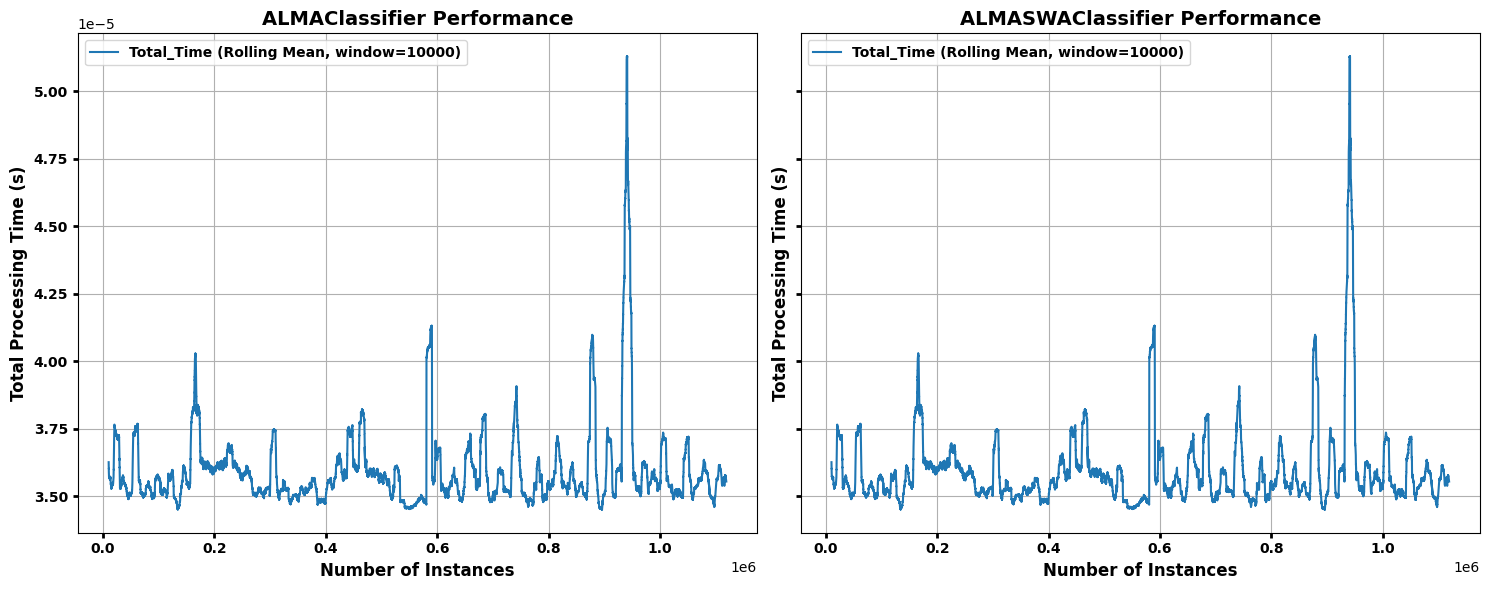

In [17]:
import pandas as pd
from collections import Counter
from sklearn.utils import shuffle
from river import compose, preprocessing, linear_model, metrics, stream
import time
import psutil
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Initialize Classifiers and Metrics
# ---------------------------

# Define classifiers with their respective pipelines
classifiers = {
    'ALMAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.ALMAClassifier()
    ),
    'ALMASWAClassifier': compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier()  # Ensure ALMASWAClassifier is correctly imported or defined
    )
}

# Initialize metrics for each classifier
metrics_dict = {
    name: {
        'Accuracy': metrics.Accuracy(),
        'F1': metrics.F1(),
        'ROCAUC': metrics.ROCAUC()
    }
    for name in classifiers
}

# Initialize performance tracking dictionaries
performance_metrics = {
    name: {
        'Latency': [],             # Time taken per sample (predict + learn)
        'Total_Time': [],          # Cumulative processing time per sample
        'CPU_Usage': [],           # CPU usage in percentage
        'Memory_Usage': []         # Memory usage in KB (Modified from MB to KB)
    }
    for name in classifiers
}

# Initialize overall tracking variables
total_samples = 0
start_time = time.time()

# Initialize psutil process for monitoring
process = psutil.Process()

# ---------------------------
# Step 2: Load and Prepare Data
# ---------------------------

# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")
print('Number of samples per class:', Counter(data['Label']))
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)

# ---------------------------
# Step 3: Training Loop with Performance Measurement
# ---------------------------

# Iterate through the data stream and update models and metrics
for i, (x, true_y) in enumerate(stream.iter_pandas(X, y)):
    total_samples += 1
    sample_start_time = time.time()

    # Get current CPU and memory usage before processing
    cpu_before = process.cpu_percent(interval=None)
    memory_before = process.memory_info().rss / 1024  # Convert to KB (Modified)

    for name, model in classifiers.items():
        clf_start_time = time.time()

        # Predict
        y_pred = model.predict_one(x)

        # Learn
        model.learn_one(x, true_y)

        # Calculate latency for this classifier
        clf_latency = time.time() - clf_start_time

        # Update metrics
        metrics_dict[name]['Accuracy'].update(true_y, y_pred)
        metrics_dict[name]['F1'].update(true_y, y_pred)
        metrics_dict[name]['ROCAUC'].update(true_y, y_pred)

        # Record latency
        performance_metrics[name]['Latency'].append(clf_latency)

    # Get current CPU and memory usage after processing
    cpu_after = process.cpu_percent(interval=None)
    memory_after = process.memory_info().rss / 1024  # Convert to KB (Modified)

    # Calculate CPU and memory usage during processing
    cpu_usage = cpu_after - cpu_before
    memory_usage = memory_after - memory_before

    # Record CPU and memory usage for each classifier (approximate)
    for name in classifiers.keys():
        performance_metrics[name]['CPU_Usage'].append(cpu_usage / len(classifiers))
        performance_metrics[name]['Memory_Usage'].append(memory_usage / len(classifiers))

    # Calculate total processing time for this sample
    total_time = time.time() - sample_start_time
    for name in classifiers.keys():
        performance_metrics[name]['Total_Time'].append(total_time / len(classifiers))

    # Optional: Print progress every 100,000 samples
    if (i + 1) % 100000 == 0:
        elapsed_time = time.time() - start_time
        throughput = total_samples / elapsed_time
        print(f'Processed {i + 1} samples. Throughput: {throughput:.2f} samples/sec.')

# ---------------------------
# Step 4: Calculate Throughput
# ---------------------------

# Calculate total elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Calculate throughput (samples per second)
throughput = total_samples / elapsed_time
print(f'\nTotal samples processed: {total_samples}')
print(f'Total elapsed time: {elapsed_time:.2f} seconds')
print(f'Throughput: {throughput:.2f} samples/second\n')

# ---------------------------
# Step 5: Display Results
# ---------------------------

# Display classification metrics
for name, metric in metrics_dict.items():
    print(f'--- {name} ---')
    print(f"Accuracy: {metric['Accuracy'].get():.4f}")
    print(f"F1 Score: {metric['F1'].get():.4f}")
    print(f"ROCAUC Score: {metric['ROCAUC'].get():.4f}\n")

# Display performance metrics summary
for name, metrics_perf in performance_metrics.items():
    avg_latency = sum(metrics_perf['Latency']) / len(metrics_perf['Latency']) if metrics_perf['Latency'] else 0
    avg_cpu = sum(metrics_perf['CPU_Usage']) / len(metrics_perf['CPU_Usage']) if metrics_perf['CPU_Usage'] else 0
    avg_memory = sum(metrics_perf['Memory_Usage']) / len(metrics_perf['Memory_Usage']) if metrics_perf['Memory_Usage'] else 0
    avg_total_time = sum(metrics_perf['Total_Time']) / len(metrics_perf['Total_Time']) if metrics_perf['Total_Time'] else 0

    print(f'--- {name} Performance ---')
    print(f"Average Latency per Sample: {avg_latency * 1000:.4f} ms")
    print(f"Average CPU Usage: {avg_cpu:.2f}%")
    print(f"Average Memory Usage: {avg_memory:.2f} KB")  # Modified to KB
    print(f"Average Total Processing Time per Sample: {avg_total_time * 1000:.4f} ms\n")

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# ---------------------------
# Step 6: (Optional) Visualization of Performance Metrics
# ---------------------------

# Enhanced Plotting Function to handle multiple classifiers side by side
def plot_performance_side_by_side(performance_metrics, classifier_names, window_size=10000):
    metrics_names = ['Total_Time']
    num_classifiers = len(classifier_names)
    
    # Create subplots arranged side by side with shared y-axis
    fig, axes = plt.subplots(1, num_classifiers, figsize=(15, 6), sharey=True)
    
    # If there's only one classifier, axes might not be a list
    if num_classifiers == 1:
        axes = [axes]
    
    for ax, classifier_name in zip(axes, classifier_names):
        for metric in metrics_names:
            metric_series = pd.Series(performance_metrics[classifier_name][metric])
            rolling_metric = metric_series.rolling(window=window_size).mean()
            ax.plot(rolling_metric, label=f'{metric} (Rolling Mean, window={window_size})')
        
        # Set titles and labels with bold font
        ax.set_title(f'{classifier_name} Performance', fontweight='bold', fontsize=14)
        ax.set_xlabel('Number of Instances', fontweight='bold', fontsize=12)
        ax.set_ylabel('Total Processing Time (s)', fontweight='bold', fontsize=12)
        
        # Make ticks bold
        ax.tick_params(axis='both', which='major', labelsize=10, width=2)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        
        # Make legend bold using prop
        ax.legend(prop={'weight': 'bold'})
        ax.grid(True)

    # Force y-axis tick labels to be bold on all subplots
    for ax in axes:
        for tick in ax.yaxis.get_ticklabels():
            tick.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig('/Users/promisea/SAMKNN/ALMASWA/CSE_Time.png')
    plt.show()

# Example: Plot performance metrics for both classifiers side by side
plot_performance_side_by_side(performance_metrics, ['ALMAClassifier', 'ALMASWAClassifier'])

## Experiment 8: Effect of Varying SWA Frequency and SWA Start on performance

### Varying SWA Frequency


Evaluating SWA Frequency: 10
Final Recall for SWA Frequency 10: 0.9995

Evaluating SWA Frequency: 50
Final Recall for SWA Frequency 50: 0.9995

Evaluating SWA Frequency: 100
Final Recall for SWA Frequency 100: 0.9995

Evaluating SWA Frequency: 200
Final Recall for SWA Frequency 200: 0.9995

Evaluating SWA Frequency: 500
Final Recall for SWA Frequency 500: 0.9995

Evaluating SWA Frequency: 1000
Final Recall for SWA Frequency 1000: 0.9995

Evaluating SWA Frequency: 5000
Final Recall for SWA Frequency 5000: 0.9991

Evaluating SWA Frequency: 10000
Final Recall for SWA Frequency 10000: 0.9982

=== Experiment Results ===
SWA Frequency: 10 | Recall: 0.9995
SWA Frequency: 50 | Recall: 0.9995
SWA Frequency: 100 | Recall: 0.9995
SWA Frequency: 200 | Recall: 0.9995
SWA Frequency: 500 | Recall: 0.9995
SWA Frequency: 1000 | Recall: 0.9995
SWA Frequency: 5000 | Recall: 0.9991
SWA Frequency: 10000 | Recall: 0.9982

Optimal SWA Frequency: 50 with Recall: 0.9995


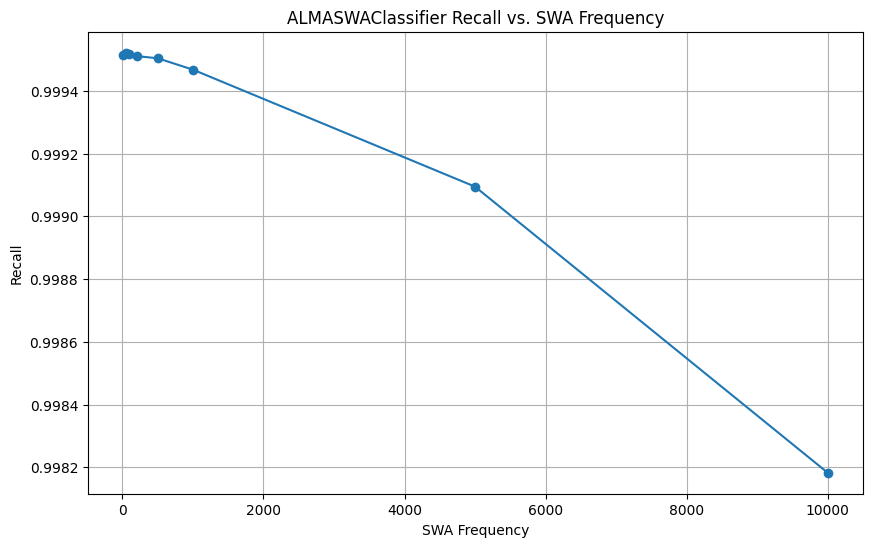

In [18]:
import pandas as pd
from sklearn.utils import shuffle
from river import compose, preprocessing, metrics, stream
import matplotlib.pyplot as plt

# Load and prepare data
data = pd.read_csv("/Users/promisea/SAMKNN/NF-CSE-CIC-IDS2018/NF-CSE.csv")
X = data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Label'], axis=1)
y = data['Label']
X, y = shuffle(X, y, random_state=42)  # Shuffle the data to ensure randomness

# Define the list of SWA frequencies to experiment with
swa_frequencies = [10, 50, 100, 200, 500, 1000, 5000, 10000]

# Initialize a dictionary to store accuracy results for each SWA frequency
recall_results = {}

# Iterate over each SWA frequency to evaluate performance
for freq in swa_frequencies:
    print(f"\nEvaluating SWA Frequency: {freq}")

    # Define the pipeline with StandardScaler and ALMASWAClassifier
    model = compose.Pipeline(
        preprocessing.StandardScaler(),
        ALMASWAClassifier(swa_freq=freq)
    )
    
    # Initialize the accuracy metric
    recall = metrics.Recall()
    
    # Stream the data and update the model and metric
    for xi, yi_true in stream.iter_pandas(X, y):
        y_pred = model.predict_one(xi)  # Make a prediction
        model.learn_one(xi, yi_true)    # Update the model with the true label
        recall.update(yi_true, y_pred)  # Update the accuracy metric
    
    # Store the final accuracy for this SWA frequency
    final_recall = recall.get()
    recall_results[freq] = final_recall
    print(f"Final Recall for SWA Frequency {freq}: {final_recall:.4f}")

# Identify the SWA frequency with the highest accuracy
best_freq = max(recall_results, key=recall_results.get)
best_recall = recall_results[best_freq]

print("\n=== Experiment Results ===")
for freq, rec in recall_results.items():
    print(f"SWA Frequency: {freq} | Recall: {rec:.4f}")
    
print(f"\nOptimal SWA Frequency: {best_freq} with Recall: {best_recall:.4f}")

# Optional: Plot the results for visualization
plt.figure(figsize=(10, 6))
plt.plot(list(recall_results.keys()), list(recall_results.values()), marker='o', linestyle='-')
plt.title('ALMASWAClassifier Recall vs. SWA Frequency')
plt.xlabel('SWA Frequency')
plt.ylabel('Recall')
plt.grid(True)
plt.show()